# From Pixels to Patterns: A Step-by-Step Guide to CNNs in PyTorch

This interactive Colab notebook will guide you from basic convolution operations to building a VGG-like CNN, with progressively complex datasets and visualizations of internal layer outputs. Ideal for students who already know MLPs and are ready to explore the power of convolutional architectures.

In [176]:
import importlib
import subprocess
import sys
from collections import OrderedDict
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from torchview import draw_graph
from torchvision import transforms
from torchvision.datasets import MNIST

In [177]:
def ensure_package_installed(package_name, import_name=None):
    """
    Ensures a Python package is installed and imported.

    Args:
        package_name (str): Name used in pip install (e.g., 'torchinfo').
        import_name (str): Module name used in import (e.g., 'torchinfo', 'sklearn').
                           Defaults to package_name.

    Returns:
        module: The imported module object.
    """


    import_name = import_name or package_name

    try:
        return importlib.import_module(import_name)
    except ImportError:
        print(f"Installing '{package_name}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        return importlib.import_module(import_name)

In [178]:
def get_device_type(verbose: bool = True) -> torch.device:
    """
    Returns the best available device: CUDA → MPS → CPU
    Explicitly separates 'is_built' and 'is_available' checks for both backends.
    """
    if verbose:
        print("Detecting best available device...")

    # ------------------- CUDA -------------------
    cuda_built = torch.version.cuda is not None
    cuda_available = torch.cuda.is_available()

    if cuda_built:
        if cuda_available:
            device = torch.device("cuda")
            if verbose:
                print(f"CUDA → Built: Yes | Available: Yes → Using {device}")
                print(
                    f"   GPU: {torch.cuda.get_device_name(0)} | Count: {torch.cuda.device_count()}"
                )
            return device
        elif verbose:
            print("CUDA → Built: Yes | Available: No (driver/GPU issue)")
    elif verbose:
        print("CUDA → Built: No (PyTorch compiled without CUDA support)")

    # ------------------- MPS (Apple Silicon) -------------------
    mps_built = torch.backends.mps.is_built()
    mps_available = torch.backends.mps.is_available()

    if mps_built:
        if mps_available:
            device = torch.device("mps")
            if verbose:
                print(
                    f"MPS → Built: Yes | Available: Yes → Using {device} (Apple Silicon GPU)"
                )
            return device
        elif verbose:
            print("MPS → Built: Yes | Available: No (macOS <12.3 or Intel Mac)")
    elif verbose:
        print("MPS → Built: No (PyTorch compiled without MPS support)")

    # ------------------- CPU Fallback -------------------
    device = torch.device("cpu")
    if verbose:
        print("Falling back to CPU")
    return device

device = get_device_type(True)


Detecting best available device...
CUDA → Built: No (PyTorch compiled without CUDA support)
MPS → Built: Yes | Available: Yes → Using mps (Apple Silicon GPU)


In [179]:
torchview = ensure_package_installed('torchview')
torchinfo = ensure_package_installed('torchinfo')

## Load MNIST Dataset
We begin with a simple grayscale dataset: MNIST.

In [180]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset_mnist = MNIST(root='./data', train=True, download=True, transform=transform)
testset_mnist = MNIST(root='./data', train=False, download=True, transform=transform)

trainloader_mnist = DataLoader(trainset_mnist, batch_size=64, shuffle=True)
testloader_mnist = DataLoader(testset_mnist, batch_size=64, shuffle=False)

## Visualize Sample Images

In [181]:
def show_images(images, labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axs[i].imshow(images[i][0], cmap='gray')
        axs[i].set_title(f"Label: {labels[i].item()}")
        axs[i].axis('off')
    plt.show()



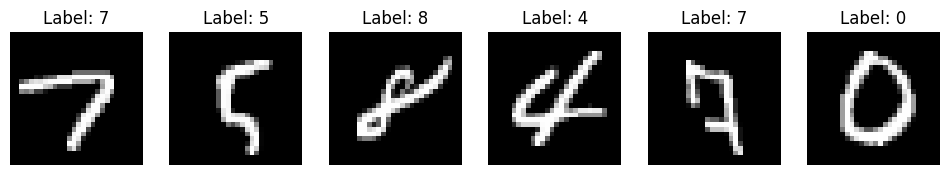

In [182]:
images_mnist, labels_mnist = next(iter(trainloader_mnist))
show_images(images_mnist, labels_mnist)

In [183]:
images_mnist.shape

torch.Size([64, 1, 28, 28])

## Step 1: Simple CNN (1 Conv Layer + Pooling)

In [184]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, input_size=(28, 28)):
        """
        A simple CNN that adapts to different input sizes and channels.

        Parameters:
        - input_channels (int): Number of channels in the input image (1 for MNIST, 3 for CIFAR-10)
        - input_size (tuple): Tuple of (height, width) of the input image
        """
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Dynamically compute the flattened size after conv + pool
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, *input_size)
            x = self.pool(F.relu(self.conv(dummy_input)))
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flattened_size, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        self.feature_maps = x.clone() # Save a copy of the output of convolution
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


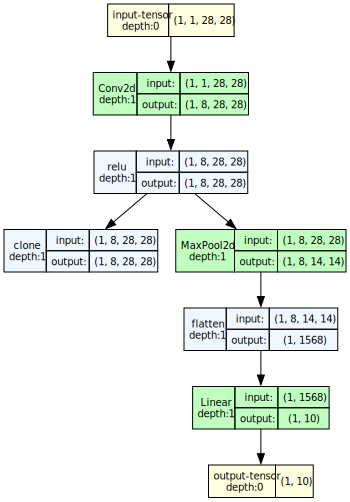

In [185]:
# prompt: Display the architecture of SimpleNet using a library


model_simple = SimpleCNN().to(device)

# Display the model architecture
model_graph = draw_graph(model_simple, input_size=(1, 1, 28, 28), expand_nested=True)
model_graph.visual_graph

In [186]:
summary(SimpleCNN(input_channels=1, input_size=(28, 28)), input_size=(1, 1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            80
├─MaxPool2d: 1-2                         [1, 8, 14, 14]            --
├─Linear: 1-3                            [1, 10]                   15,690
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.06
Estimated Total Size (MB): 0.12

In [187]:
model = SimpleCNN()
conv_weights = model.conv.weight  # shape: [out_channels, in_channels, kernel_h, kernel_w]
conv_bias = model.conv.bias       # shape: [out_channels]
print("Conv Weights:", conv_weights.shape)
print("Conv Bias:", conv_bias.shape)

# If you want the parameters for the first filter (i.e. filter 0):
filter0_weights = conv_weights[0]     # shape: [in_channels, 3, 3]
filter0_bias = conv_bias[0]           # scalar

# Use .numel() to count the number of learnable parameters
filter0_param_count = filter0_weights.numel() + filter0_bias.numel()  # 9 + 1 = 10
print("Filter 0 Param Count:", filter0_param_count)

Conv Weights: torch.Size([8, 1, 3, 3])
Conv Bias: torch.Size([8])
Filter 0 Param Count: 10


In [188]:
total_params = sum(p.numel() for p in model.conv.parameters())
print(f"Total parameters in conv layer: {total_params}")  # Expect 80

# Also confirm shapes
print("Weight shape:", model.conv.weight.shape)  # [8, 1, 3, 3]
print("Bias shape:", model.conv.bias.shape)      # [8]

Total parameters in conv layer: 80
Weight shape: torch.Size([8, 1, 3, 3])
Bias shape: torch.Size([8])


For the final fully connected layer:

Each neuron with ```n``` inputs will need ```n+1``` parameters (one weight for each input + bias).

<div align="center">
<IMG SRC='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTxNSWgBHZ9Aujox-pMCexn5M5z_--nzjjhmg&s'>
</div>

### Visualize Feature Maps from the First Convolution

In [189]:
def plot_feature_maps_with_original(original, features, title="Feature Maps"):
    original_img = original[0].permute(1, 2, 0).cpu().detach().numpy()
    is_grayscale = original.shape[1] == 1

    num_show = min(4, features.shape[1])
    total = num_show * 2 + 1

    fig, axs = plt.subplots(1, total, figsize=(2 * total, 3))

    for i in range(num_show):
        axs[i].imshow(features[0, i].cpu().detach(), cmap='viridis')
        axs[i].axis('off')

    mid_ax = axs[num_show]
    if is_grayscale:
        mid_ax.imshow(original_img[:, :, 0], cmap='gray')
    else:
        mid_ax.imshow(original_img)
    mid_ax.set_title("Original")
    mid_ax.axis('off')

    for i in range(num_show):
        axs[num_show + 1 + i].imshow(features[0, -num_show + i].cpu().detach(), cmap='viridis')
        axs[num_show + 1 + i].axis('off')

    fig.suptitle(title)
    plt.show()

### Run Model on Sample and Visualize

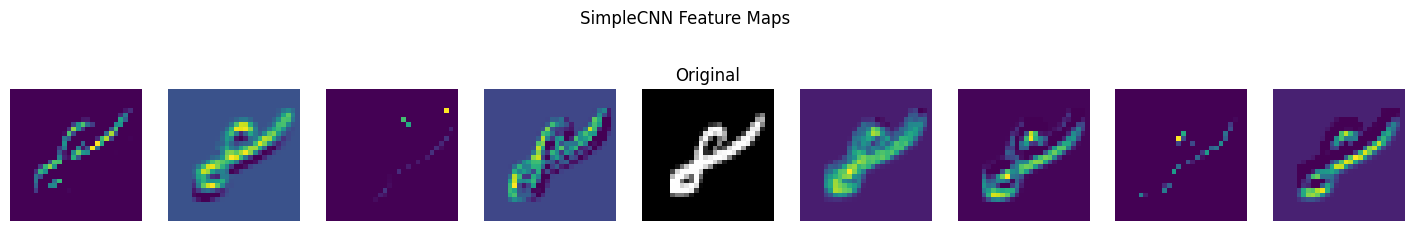

In [190]:
model = SimpleCNN(input_channels=1).to(device)
image = images_mnist[2:3].to(device)
output = model(image)
plot_feature_maps_with_original(image, model.feature_maps, "SimpleCNN Feature Maps")

In [191]:
print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 10])
Output: tensor([[-0.1434,  0.1105,  0.1521, -0.1560, -0.1232, -0.0581, -0.1243, -0.0807,
         -0.0440, -0.1119]], device='mps:0', grad_fn=<LinearBackward0>)


## Up Next
We'll add more convolutional layers, explore pooling, and introduce richer datasets like CIFAR-10 and face images. Each step will allow visual inspection of intermediate outputs and their sizes.

> **Optional Exercise:** Try changing the number of output channels in the convolution layer and observe the effect on the feature maps.

## Step 2: Add More Convolutional Layers
Now we'll deepen our network to allow the model to learn more abstract features. We'll also shift to CIFAR-10, a more complex dataset with color images.

In [192]:
# class DeeperCNN(nn.Module):
#     def __init__(self, input_channels=1, input_size=(28, 28)):
#         """
#         A deeper CNN model that adapts to different input resolutions and channels.

#         Parameters:
#         - input_channels (int): Number of input image channels (e.g., 1 for MNIST, 3 for CIFAR-10)
#         - input_size (tuple): Height and width of input images (e.g., (28, 28), (32, 32))
#         """
#         super().__init__()
#         self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2)

#         # Dynamically calculate the flattened size after two convolutions and pooling
#         with torch.no_grad():
#             dummy_input = torch.zeros(1, input_channels, *input_size)
#             x = F.relu(self.conv1(dummy_input))
#             x = self.pool(x)
#             x = F.relu(self.conv2(x))
#             x = self.pool(x)
#             self.flattened_size = x.view(1, -1).shape[1]

#         self.fc = nn.Linear(self.flattened_size, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         self.feat1 = x.clone()
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         self.feat2 = x.clone()
#         x = self.pool(x)
#         x = torch.flatten(x, 1)
#         return self.fc(x)


In [ ]:

def build_conv_downsampler(input_channels, channel_config):
    """Build a convolutional downsampler with configurable depth.

    Each layer consists of: Conv2d → ReLU → MaxPool2d
    Downsampling factor: 2^len(channel_config)

    Args:
        input_channels: Number of input channels (1 for grayscale, 3 for RGB)
        channel_config: List of output channels for each conv layer
                        E.g., [16, 32] creates 2 conv layers
                        E.g., [32, 64, 128] creates 3 conv layers

    Returns:
        nn.Sequential with named layers for easy inspection

    Example:
        >>> backbone = build_conv_downsampler(3, [32, 64, 128])
        >>> # Creates: conv1(3→32) → relu1 → pool1 →
        >>> #          conv2(32→64) → relu2 → pool2 →
        >>> #          conv3(64→128) → relu3 → pool3
    """
    layers = OrderedDict()

    for i, out_channels in enumerate(channel_config, 1):
        # Determine input channels for this layer
        in_channels = input_channels if i == 1 else channel_config[i-2]

        # Add conv → relu → pool block
        layers[f'conv{i}'] = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        layers[f'relu{i}'] = nn.ReLU()
        layers[f'pool{i}'] = nn.MaxPool2d(2)

    return nn.Sequential(layers)


class DeeperCNN(nn.Module):
    """Convolutional Neural Network with automatic feature map capture.

    Features:
    - Parameterized architecture via channel_config
    - Automatic hook registration for all ReLU outputs
    - Flexible feature map access (dict or list)
    - Educational: clear method names and documentation

    Example:
        >>> model = DeeperCNN(input_channels=3, channel_config=[32, 64, 128])
        >>> output = model(torch.randn(1, 3, 32, 32))
        >>>
        >>> # Access features as dict
        >>> features = model.get_feature_maps()
        >>> print(features.keys())  # ['relu1', 'relu2', 'relu3']
        >>>
        >>> # Access features as list
        >>> feature_list = model.get_feature_maps(as_list=True)
        >>> for i, fmap in enumerate(feature_list):
        >>>     print(f"Layer {i}: {fmap.shape}")
    """

    def __init__(self, input_channels=1, input_size=(28, 28), channel_config=None, num_classes=10):
        """Initialize DeeperCNN.

        Args:
            input_channels: Number of input channels (1 for grayscale, 3 for RGB)
            input_size: Tuple of (height, width) of input images
            channel_config: List of channel counts for each conv layer
                            Default None creates 2-layer network with [16, 32]
                            Can use [32, 64, 128, 256] for deeper network
            num_classes: Number of output classes for classification
        """
        super().__init__()

        # Use default channel config if not provided
        if channel_config is None:
            channel_config = [16, 32]

        # Build feature extraction backbone
        self.features = build_conv_downsampler(input_channels, channel_config)

        # Calculate flattened size after all pooling layers
        # Each pool layer reduces spatial dimensions by 2x
        downsampling_factor = 2 ** len(channel_config)
        output_h = input_size[0] // downsampling_factor
        output_w = input_size[1] // downsampling_factor
        final_channels = channel_config[-1]
        self.flattened_size = final_channels * output_h * output_w

        # Classifier head
        self.fc = nn.Linear(self.flattened_size, num_classes)

        # Feature map storage (populated by hooks during forward pass)
        self.feature_maps = {}

        # Register hooks to automatically capture ReLU outputs
        self._register_hooks()

    def _register_hooks(self):
        """Register forward hooks to automatically capture feature maps.

        Hooks are attached to all ReLU layers in the feature extractor.
        This is done automatically based on layer type, so adding more
        layers to channel_config requires no code changes here.
        """
        def create_hook(name):
            """Create a hook closure that captures the layer name."""
            def hook(module, input, output):
                self.feature_maps[name] = output.clone()
            return hook

        # Automatically find and hook all ReLU layers
        for name, module in self.features.named_modules():
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(create_hook(name))

    def get_feature_maps(self, as_list=False):
        """Get all captured feature maps.

        Args:
            as_list: If True, return list of tensors ordered by layer depth.
                    If False, return dict with layer names as keys.

        Returns:
            List or dict of feature map tensors

        Example:
            >>> # Get as dictionary (named access)
            >>> features_dict = model.get_feature_maps()
            >>> conv1_output = features_dict['relu1']
            >>>
            >>> # Get as list (ordered access)
            >>> features_list = model.get_feature_maps(as_list=True)
            >>> first_layer = features_list[0]
            >>> last_layer = features_list[-1]
        """
        if as_list:
            return list(self.feature_maps.values())
        return self.feature_maps

    def get_feature(self, name):
        """Get a specific feature map by layer name.

        Args:
            name: Layer name (e.g., 'relu1', 'relu2')

        Returns:
            Feature map tensor or None if not found

        Example:
            >>> relu1_features = model.get_feature('relu1')
            >>> print(relu1_features.shape)  # torch.Size([batch, channels, h, w])
        """
        return self.feature_maps.get(name)

    def get_layer_names(self):
        """Get names of all layers with captured features.

        Returns:
            List of layer names as strings

        Example:
            >>> layer_names = model.get_layer_names()
            >>> print(layer_names)  # ['relu1', 'relu2', ...]
        """
        return list(self.feature_maps.keys())

    def forward(self, x):
        """Forward pass through the network.

        Feature maps are automatically captured via hooks registered in __init__.
        Access them after forward pass using get_feature_maps() or get_feature().

        Args:
            x: Input tensor of shape [batch, channels, height, width]

        Returns:
            Output logits of shape [batch, num_classes]
        """
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [194]:
# Example 1: Basic Usage with 2 conv layers (default)
print("=== Example 1: Basic 2-Layer Network ===")
model = DeeperCNN(input_channels=3, input_size=(32, 32))
x = torch.randn(1, 3, 32, 32)
output = model(x)

# Access features as dict
features = model.get_feature_maps()
print(f"Feature map keys: {list(features.keys())}")
print(f"Number of feature maps captured: {len(features)}")

# Access features as list
feature_list = model.get_feature_maps(as_list=True)
print(f"Feature maps as list: {len(feature_list)} items")
for i, fmap in enumerate(feature_list):
    print(f"  Layer {i+1}: shape {fmap.shape}")

print("\n=== Example 2: Deeper 4-Layer Network ===")
# Create model with 4 conv layers
model_deep = DeeperCNN(
    input_channels=3,
    input_size=(64, 64),
    channel_config=[32, 64, 128, 256]  # 4 layers!
)
output = model_deep(torch.randn(1, 3, 64, 64))

# All 4 layers automatically captured!
print(f"Layer names: {model_deep.get_layer_names()}")
print(f"Total layers captured: {len(model_deep.get_layer_names())}")

print("\n=== Example 3: Accessing Specific Layers ===")
model_test = DeeperCNN(input_channels=3, input_size=(32, 32), channel_config=[32, 64, 128])
output = model_test(torch.randn(1, 3, 32, 32))

# Get specific layer by name
early_features = model_test.get_feature('relu1')
mid_features = model_test.get_feature('relu2')
deep_features = model_test.get_feature('relu3')

print(f"Early features (relu1): {early_features.shape}")
print(f"Mid features (relu2): {mid_features.shape}")
print(f"Deep features (relu3): {deep_features.shape}")

print("\n=== Example 4: Iterate Over All Features ===")
for name, fmap in model_test.get_feature_maps().items():
    print(f"{name:10s}: {fmap.shape}")

=== Example 1: Basic 2-Layer Network ===
Feature map keys: ['relu1', 'relu2']
Number of feature maps captured: 2
Feature maps as list: 2 items
  Layer 1: shape torch.Size([1, 16, 32, 32])
  Layer 2: shape torch.Size([1, 32, 16, 16])

=== Example 2: Deeper 4-Layer Network ===
Layer names: ['relu1', 'relu2', 'relu3', 'relu4']
Total layers captured: 4

=== Example 3: Accessing Specific Layers ===
Early features (relu1): torch.Size([1, 32, 32, 32])
Mid features (relu2): torch.Size([1, 64, 16, 16])
Deep features (relu3): torch.Size([1, 128, 8, 8])

=== Example 4: Iterate Over All Features ===
relu1     : torch.Size([1, 32, 32, 32])
relu2     : torch.Size([1, 64, 16, 16])
relu3     : torch.Size([1, 128, 8, 8])


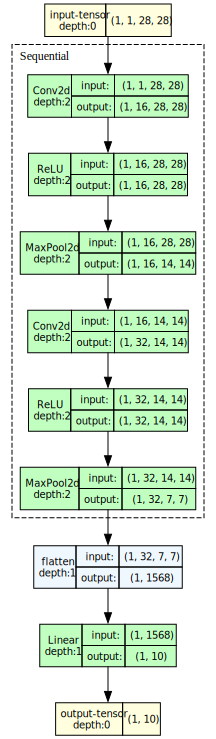

In [195]:
# Display the model architecture
model_new = DeeperCNN(input_channels=1, input_size=(28, 28))
model_graph = draw_graph(model_new, input_size=(1, 1, 28, 28), expand_nested=True)
model_graph.visual_graph

# Note: There are two options for conv2d:

## 1. Each kernel only works on one channel
## 2. Each kernel works on all channels

How will this change the number of learnable parameters?

In [196]:
summary(DeeperCNN(input_channels=1, input_size=(28, 28)), input_size=(1, 1,28,28))

# 160: 16*(3*3*1 +1)
# 4640:  32*( 3*3*16 + 1) , Why not 3*3*16+16 ?

Layer (type:depth-idx)                   Output Shape              Param #
DeeperCNN                                [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           160
│    └─ReLU: 2-2                         [1, 16, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 16, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 32, 14, 14]           4,640
│    └─ReLU: 2-5                         [1, 32, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 32, 7, 7]             --
├─Linear: 1-2                            [1, 10]                   15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.08
Estimated Total Size (MB): 0.24

<div align="center">
<IMG SRC="https://www.researchgate.net/publication/334974839/figure/fig4/AS:788678381146114@1565046987659/D-convolution-with-filter-size-3x3-49.jpg">
<IMG SRC="https://global.discourse-cdn.com/dlai/optimized/3X/c/2/c2ed4b56ec1a1b464b6b0079ac36a8c0f874723f_2_690x237.png">
</div>

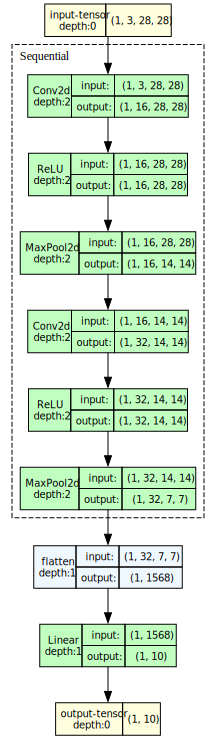

In [197]:
# Display the model architecture
model_new_RGB = DeeperCNN(input_channels=3, input_size=(28, 28))
model_graph = draw_graph(model_new_RGB, input_size=(1, 3, 28, 28), expand_nested=True)
model_graph.visual_graph

In [198]:
summary(DeeperCNN(input_channels=3, input_size=(28, 28)), input_size=(1, 3,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
DeeperCNN                                [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           448
│    └─ReLU: 2-2                         [1, 16, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 16, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 32, 14, 14]           4,640
│    └─ReLU: 2-5                         [1, 32, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 32, 7, 7]             --
├─Linear: 1-2                            [1, 10]                   15,690
Total params: 20,778
Trainable params: 20,778
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.28
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.08
Estimated Total Size (MB): 0.24

In [199]:
## OLD DeeperCNN parameter calculation

# total_params = sum(p.numel() for p in model_new_RGB.conv1.parameters())
# print(f"Total parameters in conv1 layer: {total_params}")  # Expect

# # Also confirm shapes
# print("Weight shape:", model_new_RGB.conv1.weight.shape)
# print("Bias shape:", model_new_RGB.conv1.bias.shape)

# total_params = sum(p.numel() for p in model_new_RGB.conv2.parameters())
# print(f"Total parameters in conv2 layer: {total_params}")  # Expect

# # Also confirm shapes
# print("Weight shape:", model_new_RGB.conv2.weight.shape)
# print("Bias shape:", model_new_RGB.conv2.bias.shape)

In [200]:
# Using the new DeeperCNN class in step 2, write code to confirm shapes, with similar print() output to above cell.

# Create a DeeperCNN model with RGB input
model_deeper = DeeperCNN(input_channels=3, input_size=(28, 28))

# Access conv1 from the Sequential features block (index 0)
conv1_layer = model_deeper.features[0]
total_params_conv1 = sum(p.numel() for p in conv1_layer.parameters())
print(f"Total parameters in conv1 layer: {total_params_conv1}")  # Expect 448

# Confirm shapes
print("Conv1 Weight shape:", conv1_layer.weight.shape)  # [16, 3, 3, 3]
print("Conv1 Bias shape:", conv1_layer.bias.shape)      # [16]

print()

# Access conv2 from the Sequential features block (index 3)
conv2_layer = model_deeper.features[3]
total_params_conv2 = sum(p.numel() for p in conv2_layer.parameters())
print(f"Total parameters in conv2 layer: {total_params_conv2}")  # Expect 4640

# Confirm shapes
print("Conv2 Weight shape:", conv2_layer.weight.shape)  # [32, 16, 3, 3]
print("Conv2 Bias shape:", conv2_layer.bias.shape)      # [32]

Total parameters in conv1 layer: 448
Conv1 Weight shape: torch.Size([16, 3, 3, 3])
Conv1 Bias shape: torch.Size([16])

Total parameters in conv2 layer: 4640
Conv2 Weight shape: torch.Size([32, 16, 3, 3])
Conv2 Bias shape: torch.Size([32])


In [201]:
transform = transforms.ToTensor()

trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader_cifar = DataLoader(trainset_cifar, batch_size=64, shuffle=True)
testloader_cifar = DataLoader(testset_cifar, batch_size=64, shuffle=False)

# Use correct indices for CIFAR subset
subset_indices = list(range(512))  # or however many you want
train_cifar_subset = Subset(trainset_cifar, subset_indices)
trainloader_cifar_subset = DataLoader(train_cifar_subset, batch_size=64, shuffle=True)

images_cifar, labels_cifar = next(iter(trainloader_cifar))

print("Shape of training batch:", images_cifar.shape)

Shape of training batch: torch.Size([64, 3, 32, 32])


### Visualize CIFAR-10 Images

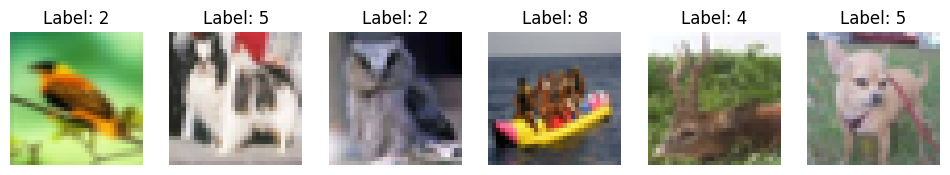

In [202]:

fig, axs = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axs[i].imshow(images_cifar[i].permute(1, 2, 0))
    axs[i].set_title(f"Label: {labels_cifar[i].item()}")
    axs[i].axis('off')
plt.show()

### Define a Deeper CNN for CIFAR-10

### Run and Visualize Intermediate Feature Maps

## Step 3: Visualize Overfitting on a Tiny Subset
To build intuition for regularization, try training on only 100 samples. Observe the gap between training and test accuracy.

We'll introduce BatchNorm and Dropout only after we understand the symptoms of overfitting.

## Step 4: Train the CNN on a Subset
To keep things fast and interactive, we'll train on a small subset of the dataset and observe the learning process.

In [203]:
# Take a small subset (e.g. 1000 samples)
subset_indices = list(range(100))
train_subset = Subset(trainset_mnist, subset_indices)
trainloader_mnist_subset = DataLoader(train_subset, batch_size=64, shuffle=True)

### Define Training and Evaluation Functions

In [204]:
def train_model(active_model, trainloader, testloader, epochs=5):
    print("Training model structure:")
    print(active_model)  # ADD THIS

    active_model = active_model.to(device)
    optimizer = torch.optim.Adam(active_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_acc, test_acc = [], []

    for epoch in range(epochs):
        active_model.train()
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = active_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc.append(correct / total)

        # Evaluate on test set
        active_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                preds = active_model(inputs).argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        test_acc.append(correct / total)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc[-1]:.3f}, Test Acc = {test_acc[-1]:.3f}")

    return train_acc, test_acc

In [205]:
def plot_accuracy(train_acc, test_acc):
    plt.plot(train_acc, label='Train Acc')
    plt.plot(test_acc, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Test Accuracy')
    plt.legend()
    plt.show()


### Train the SimpleCNN Model on MNIST Subset

Training model structure:
SimpleCNN(
  (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch 1: Train Acc = 0.100, Test Acc = 0.172
Epoch 2: Train Acc = 0.250, Test Acc = 0.300
Epoch 3: Train Acc = 0.400, Test Acc = 0.304


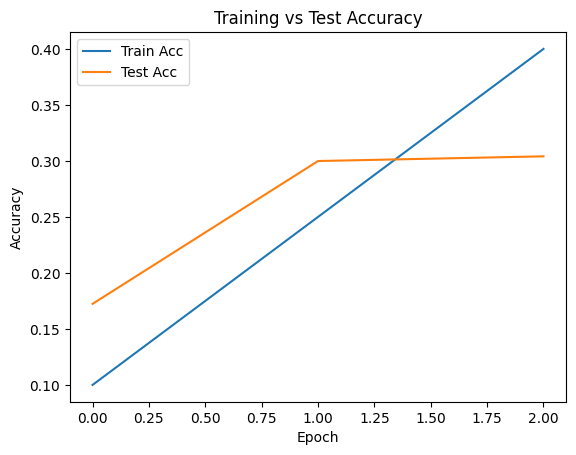

In [206]:
# Reinitialize model to reset weights
model = SimpleCNN(input_channels=1, input_size=(28, 28))

# Save untrained model state for feature map comparison
model_untrained = deepcopy(model)

train_acc, test_acc = train_model(model, trainloader_mnist_subset, testloader_mnist, epochs=3)
plot_accuracy(train_acc, test_acc)

### Compare Feature Maps: Before vs After Training

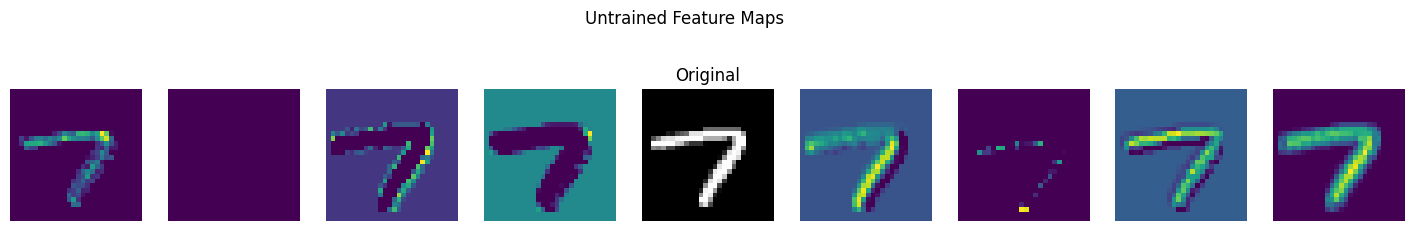

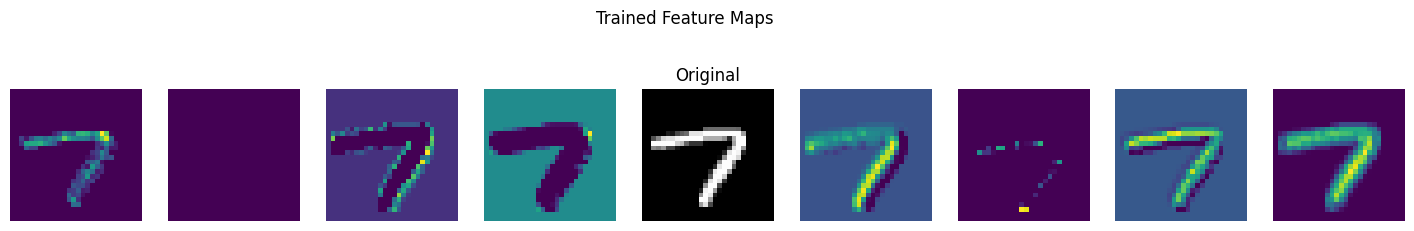

In [207]:
# Choose a sample image
image = images_mnist[0:1]#.to(device)

# Untrained
model_untrained.eval()
with torch.no_grad():
    model_untrained(image)
plot_feature_maps_with_original(image, model_untrained.feature_maps, "Untrained Feature Maps")

# Trained
model.eval()
with torch.no_grad():
    model(image.to(device))
plot_feature_maps_with_original(image, model.feature_maps, "Trained Feature Maps")

Shape of training batch: torch.Size([64, 3, 32, 32])
Training model structure:
DeeperCNN(
  (features): Sequential(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1: Train Acc = 0.140, Test Acc = 0.100
Epoch 2: Train Acc = 0.160, Test Acc = 0.100
Epoch 3: Train Acc = 0.160, Test Acc = 0.100
Epoch 4: Train Acc = 0.160, Test Acc = 0.100
Epoch 5: Train Acc = 0.160, Test Acc = 0.103
Epoch 6: Train Acc = 0.210, Test Acc = 0.129
Epoch 7: Train Acc = 0.300, Test Acc = 0.144
Epoch 8: Train Acc = 0.330, Test Acc = 0.149
Epoch 9: Train Acc = 0.360, Test Acc = 0.137
Epoch 10: Train Acc = 0.320, Test Acc =

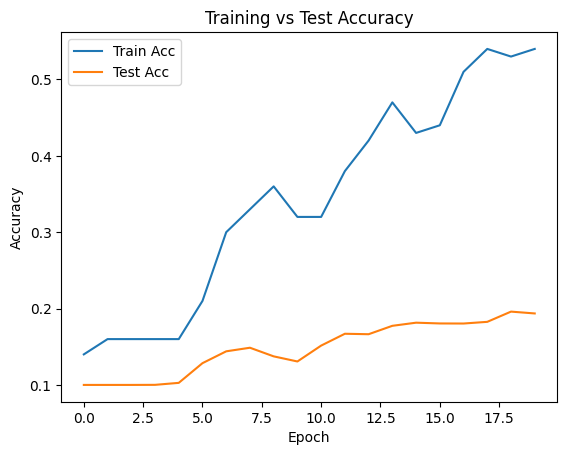

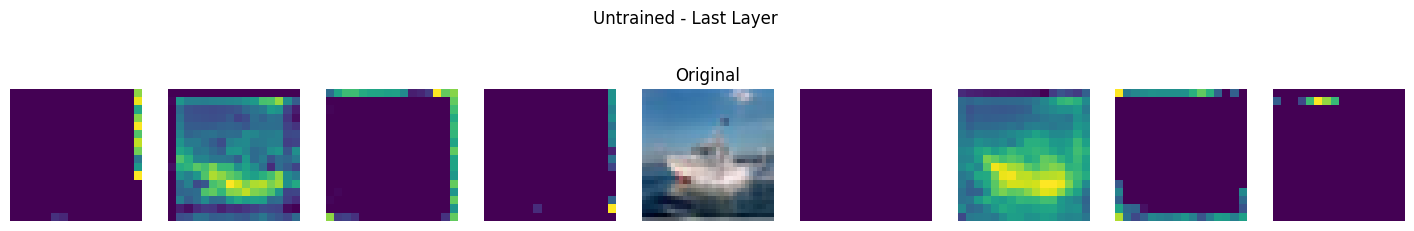

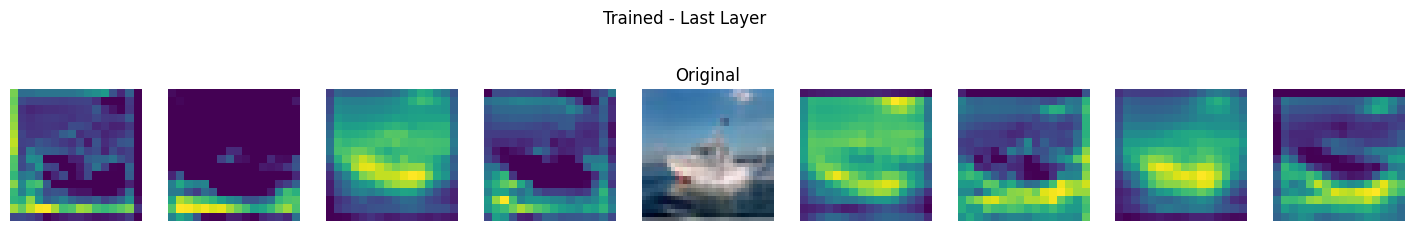


=== Visualizing all 2 layers ===
Visualizing relu1: torch.Size([1, 16, 32, 32])


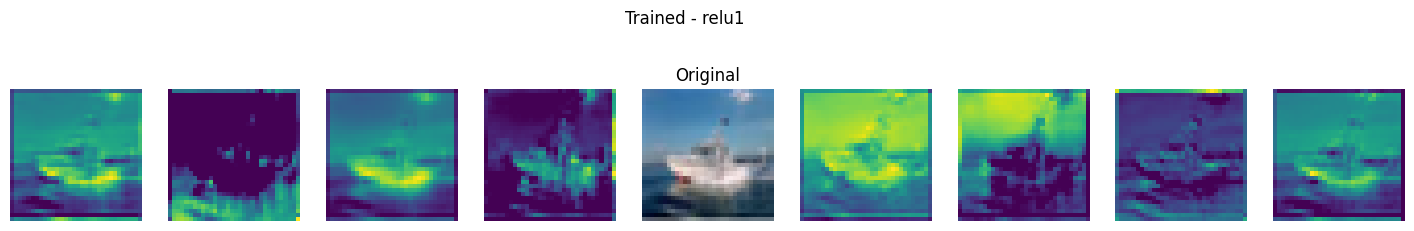

Visualizing relu2: torch.Size([1, 32, 16, 16])


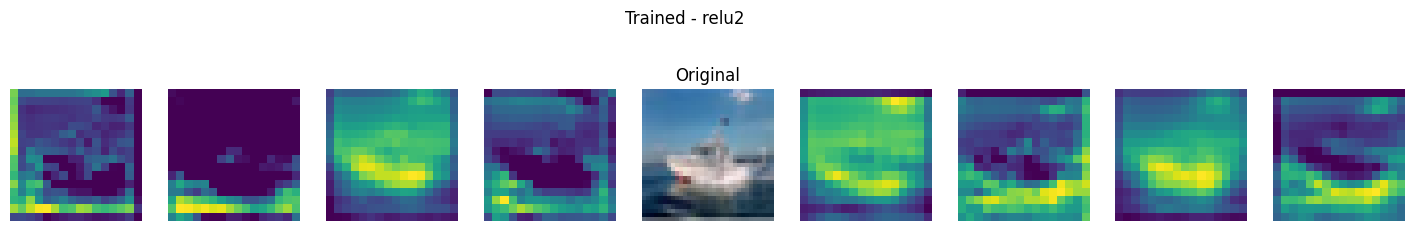

In [208]:
train_cifar_subset = Subset(trainset_cifar, subset_indices)
trainloader_cifar_subset = DataLoader(train_cifar_subset, batch_size=64, shuffle=True)

# NOTE: We create two separate model instances instead of using deepcopy()
# because PyTorch hooks are not preserved by deepcopy(). Creating fresh
# instances ensures both models have their hooks properly registered.
model2 = DeeperCNN(input_channels=3, input_size=(32, 32)).to(device)
model2_untrained = DeeperCNN(input_channels=3, input_size=(32, 32)).to(device)


# Get CIFAR image sample
images_cifar, _ = next(iter(trainloader_cifar_subset))
print("Shape of training batch:", images_cifar.shape)


# Train on CIFAR
train_acc, test_acc = train_model(model2, trainloader_cifar_subset, testloader_cifar, epochs=20)
plot_accuracy(train_acc, test_acc)



image_cifar = images_cifar[0:1].to(device)  # Send image to device too

# Untrained model - NEW API
model2_untrained.eval()
with torch.no_grad():
    model2_untrained(image_cifar)

# NEW - flexible list access for untrained model
feature_list_untrained = model2_untrained.get_feature_maps(as_list=True)
# Visualize last layer (similar to old behavior)
plot_feature_maps_with_original(image_cifar, feature_list_untrained[-1], "Untrained - Last Layer")

# Trained model - NEW API
model2.eval()
with torch.no_grad():
    model2(image_cifar)

# NEW - flexible list access for trained model
feature_list = model2.get_feature_maps(as_list=True)

# Visualize last layer
plot_feature_maps_with_original(image_cifar, feature_list[-1], "Trained - Last Layer")

# Optional: Visualize ALL layers
print(f"\n=== Visualizing all {len(feature_list)} layers ===")
for i, fmap in enumerate(feature_list):
    layer_name = model2.get_layer_names()[i]
    print(f"Visualizing {layer_name}: {fmap.shape}")
    plot_feature_maps_with_original(image_cifar, fmap, f"Trained - {layer_name}")

# Responses to classroom questions

https://classroom.google.com/c/Nzg0ODQ4MTQ2NjQz/a/NzkyNTkzODYwODAx/details



### Q1: Why is that code there? What does it do?

```python
with torch.no_grad():  # Don't compute gradients (just measuring)
    dummy_input = torch.zeros(1, input_channels, *input_size)  # Fake input
    x = F.relu(self.conv1(dummy_input))  # Pass through conv1
    x = self.pool(x)                      # Size ÷ 2
    x = F.relu(self.conv2(x))            # Pass through conv2
    x = self.pool(x)                      # Size ÷ 2 again
    self.flattened_size = x.view(1, -1).shape[1]  # Count total elements
```

> - Purpose: Calculate flattened size for nn.Linear(self.flattened_size, 10)
> - Example: Input 32×32 → pool → 16×16 → pool → 8×8, with 32 channels = 32×8×8 = 2048

### Q2: Why is this problematic?

Software Design:

```python
class SimpleCNN(nn.Module):
    def __init__(self, ...):
        self.conv1 = ...
        with torch.no_grad():  # Why is there a forward pass here?
            ...


model = DeeperCNN()  # Runs full forward pass EVERY time!
```

1. Performance penalty - Unnecessary computation on every instantiation
1. Not reusable - Logic duplicated across model classes
1. Tight coupling - Layer structure tied to measurement code
1. Violates the programming principles of SOLID's, [Single Responsibility Principle](https://blog.bitsrc.io/single-responsibility-principle-practical-guide-to-writing-maintainable-code-50ec261819b7) (SRP) - Constructor does computation, not just setup


### Q3: Show 3 solutions with pros/cons

#### Solution 1: Manual Math

```python
def __init__(self, input_channels=1, input_size=(28, 28)):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2)
    
    # Calculate: 2 pools = divide by 4
    H, W = input_size
    H = H // 2 // 2  # Two pools
    W = W // 2 // 2
    self.flattened_size = 32 * H * W  # channels × H × W
    
    self.fc = nn.Linear(self.flattened_size, 10)
```
>- Pros: Zero overhead, explicit
>- Cons: Manual update when layers change, error-prone

#### Solution 2: LazyLinear

```python
def __init__(self, input_channels=1, input_size=(28, 28)):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2)
    
    self.fc = nn.LazyLinear(10)  # Infers size on first forward pass

def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    return self.fc(x)  # Size inferred here on first call
```
>- Pros: One line, always correct, no maintenance
>- Cons: Size unknown until runtime, delayed initialization

#### Solution 3: Programmatic Calculation (Generalized)

```python
def __init__(self, input_channels=1, input_size=(28, 28), 
             channel_config=None):
             
    super().__init__()
    
    if channel_config is None:
        channel_config = [16, 32]
    
    self.features = build_conv_downsampler(input_channels, channel_config)
    
    # General formula: 2^n downsampling for n pools
    downsampling_factor = 2 ** len(channel_config)  # 2^2 = 4
    output_size = input_size[0] // downsampling_factor  # 32 // 4 = 8
    self.flattened_size = channel_config[-1] * output_size ** 2  # 32 × 64
    
```

>- Pros: Zero overhead, scales to any depth, reusable
>- Cons: Assumes uniform pattern (one pool per layer)

### Q4: Can hooks solve this?
No for size calculation:

#### Hooks run DURING forward pass
#### Size needed BEFORE any forward pass (in __init__)
Yes for feature capture:

```python
# OLD: Manual (clutters forward())
def forward(self, x):
    x = F.relu(self.conv1(x))
    self.feat1 = x.clone()  # Manual capture
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    self.feat2 = x.clone()  # Manual capture
    # ...

# NEW: Hooks (automatic)
def __init__(self, ...):
    # ... setup layers ...
    self.feature_maps = {}
    self._register_hooks()

def _register_hooks(self):
    def create_hook(name):
        def hook(module, input, output):
            self.feature_maps[name] = output.clone()
        return hook
    
    # Auto-hook all ReLU layers
    for name, module in self.features.named_modules():
        if isinstance(module, nn.ReLU):
            module.register_forward_hook(create_hook(name))

def forward(self, x):
    x = self.features(x)  # Hooks capture automatically
    x = torch.flatten(x, 1)
    return self.fc(x)
```

>- Pros: Scales to any depth, no forward() clutter, zero maintenance
>- Cons: Not preserved by `deepcopy()`, harder to understand

#### Custom __deepcopy__ (Re-register hooks automatically)

```python
class DeeperCNN(nn.Module):
    def __init__(self, ...):
        # ... setup layers ...
    
    def __deepcopy__(self, memo):
        """Custom deepcopy that preserves hooks."""
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        
        # Copy all attributes except feature_maps (runtime data)
        for k, v in self.__dict__.items():
            if k != 'feature_maps':
                setattr(result, k, deepcopy(v, memo))
        
        # Re-initialize feature maps and hooks
        result.feature_maps = {}
        result._register_hooks()  # Re-register hooks on copied model
        
        return result
    
    def _register_hooks(self):
        # ... register hooks ...

# Usage:

model = DeeperCNN(input_channels=3, input_size=(32, 32)).to(device)
model_copy = deepcopy(model) # Hooks preserved automatically
```
  
>- Pros: Transparent, deepcopy() just works
>- Cons: Complex for beginners, magic behavior